interactive(children=(IntText(value=101, description='node'), Dropdown(description='component', options=('hold…

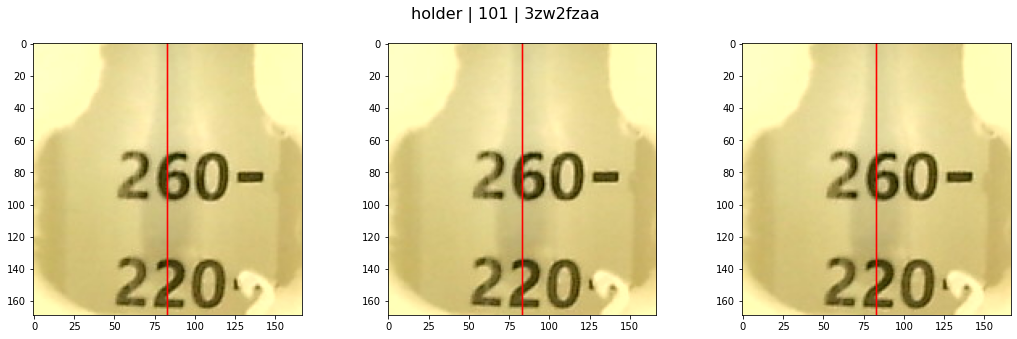

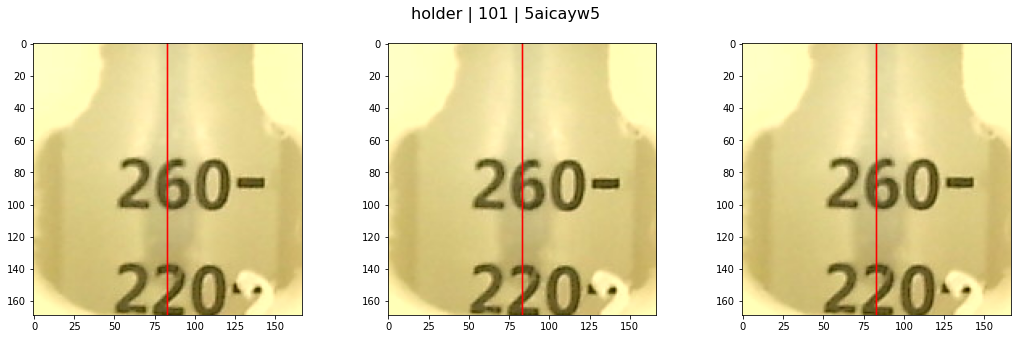

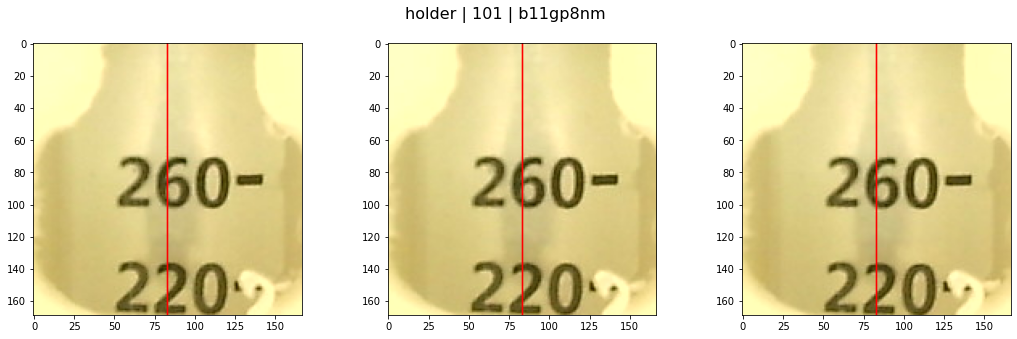

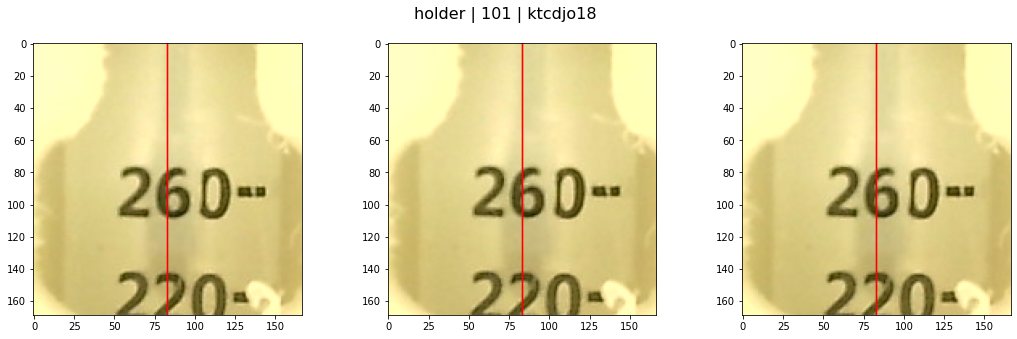

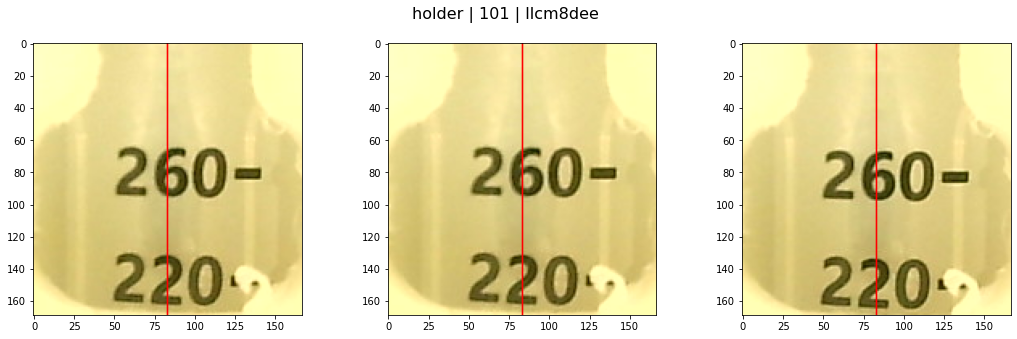

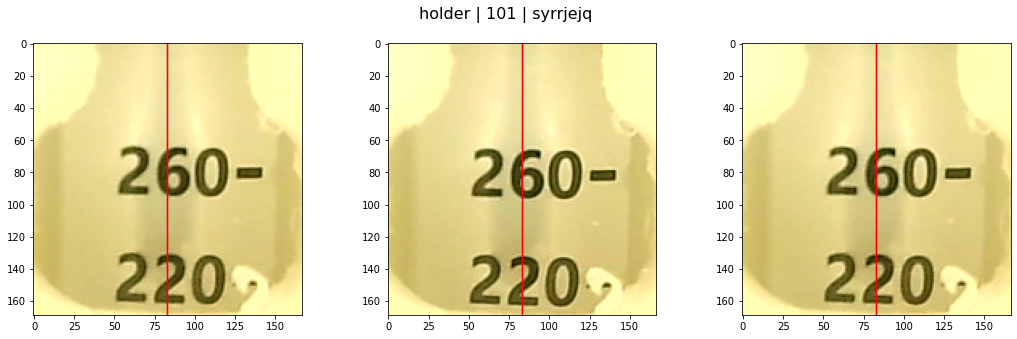

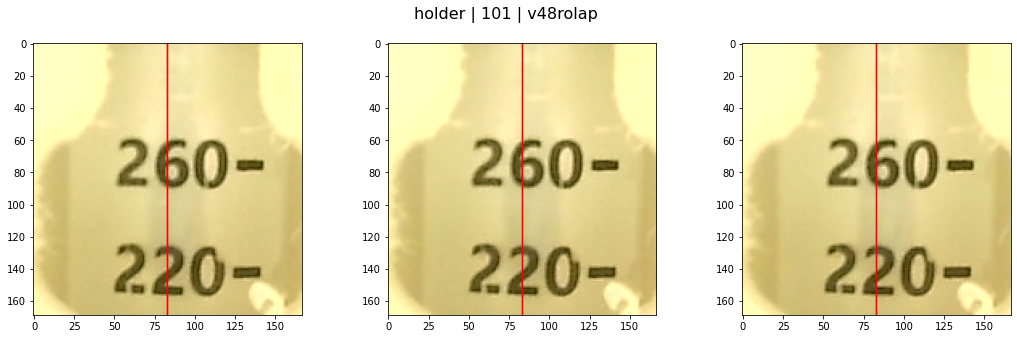

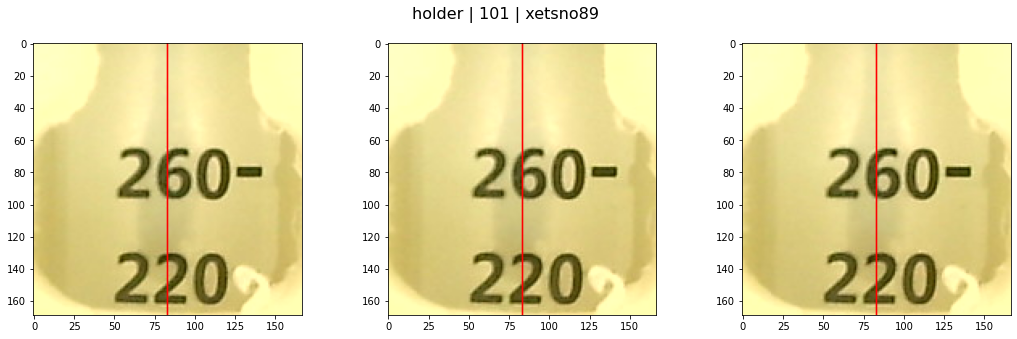

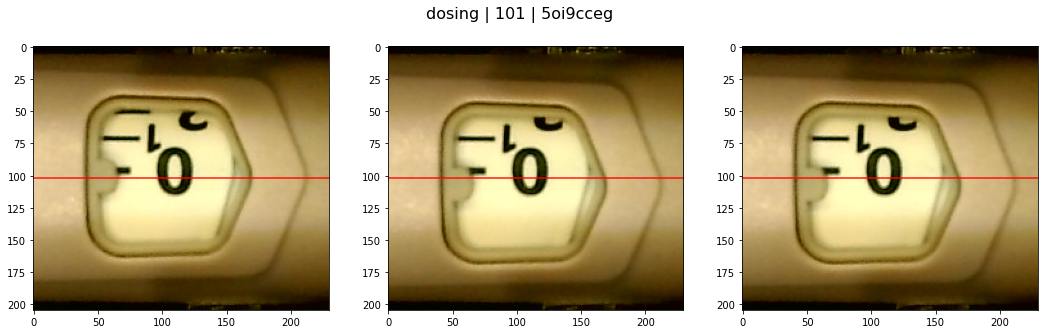

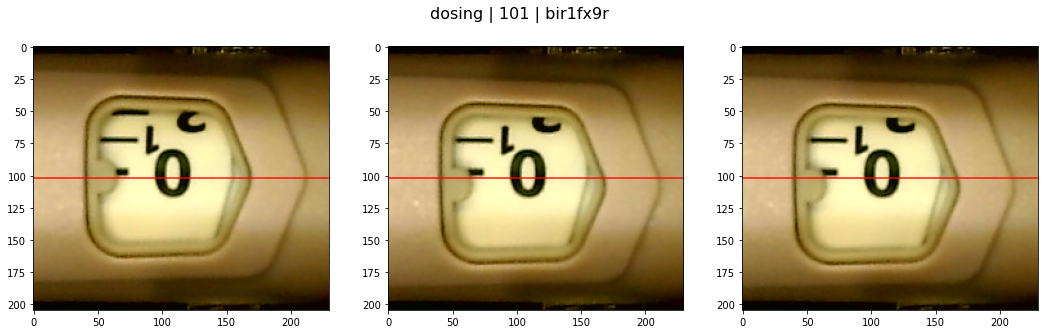

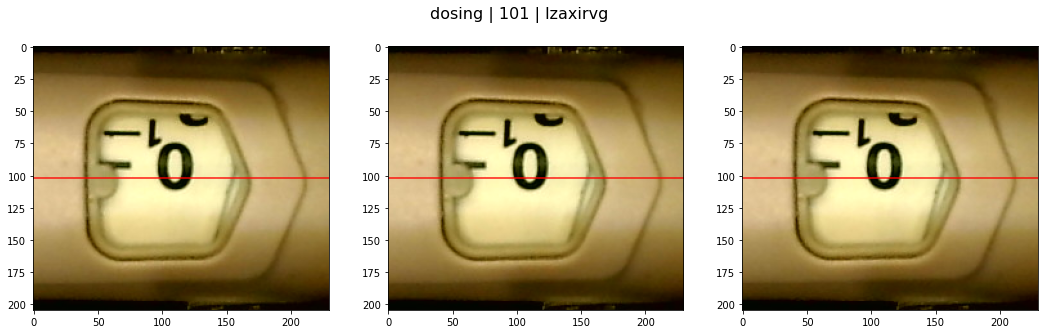

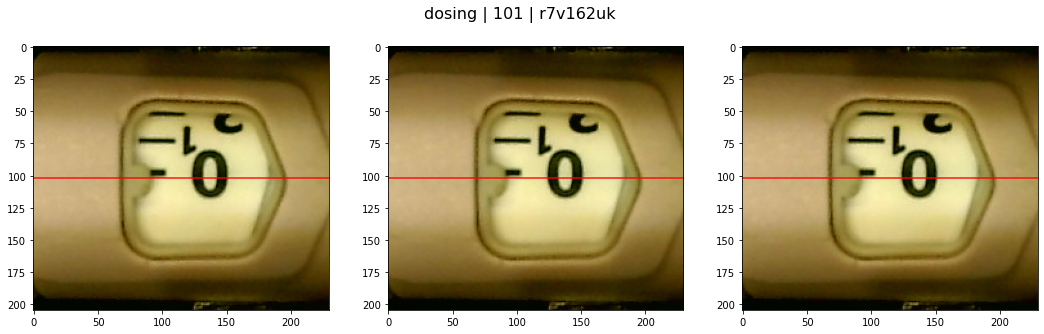

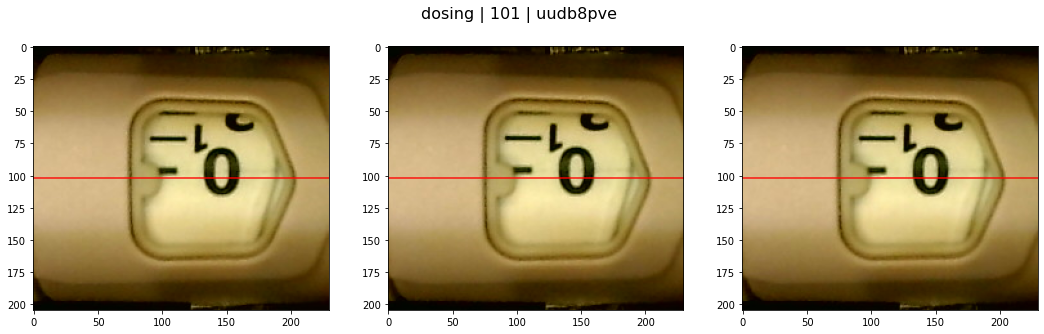

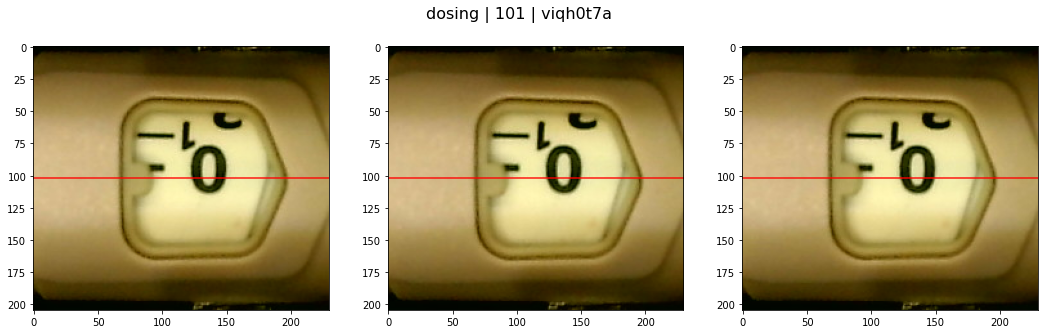

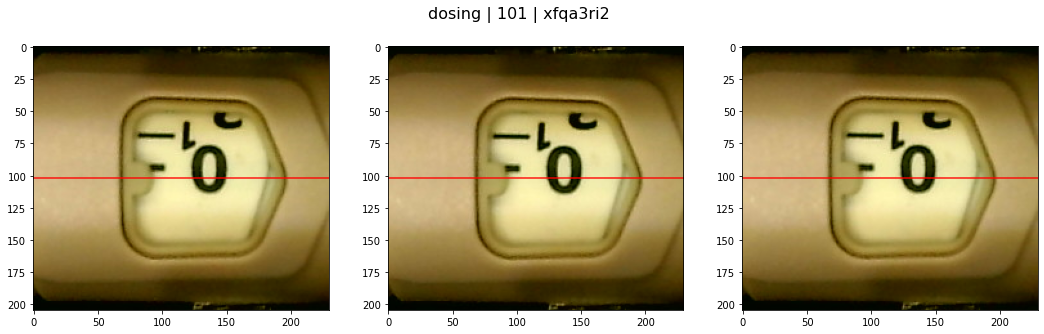

In [3]:
import json
import glob
from ipywidgets import *
import matplotlib.pyplot as plt
import cv2
import copy


def load_data():
    with open('annotaion.json') as f:
        data = json.loads(f.read())
    return data


def save_data():
    global data_saved_json
    data_json = json.dumps(data, sort_keys=True, indent=4)
    if data_saved_json != data_json:
        data_saved_json = data_json
        with open('annotaion.json', 'w') as f:
            f.write(data_saved_json)


def display_set(zero, node, component, dataset_name):
    roi = data[str(node)][component+'_roi']
    dataset = data[str(node)][component][dataset_name]
    path = '../../dataset/%s_%d_%s_192.168.44.%d' % (component, node, dataset_name, node)
    files = glob.glob(path + '/*.png')

    zero_filenames = [filename for filename in files if int(filename.split('/')[-1].split('_')[0]) == zero]


    x0 = roi['x0']
    x1 = roi['x0'] + roi['dx']
    y0 = roi['y0']
    y1 = roi['y0'] + roi['dy']

    fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (18,5))
    fig.suptitle(' | '.join([component, str(node), dataset_name]), size=16)
    for index, filename in enumerate(zero_filenames):
        image = cv2.imread(filename)[y0:y1,x0:x1,::-1]
        if component == 'holder':
            midpoint = int(image.shape[1] / 2)
            image[:,midpoint:midpoint+1,0] = 255
            image[:,midpoint:midpoint+1,1] = 0
            image[:,midpoint:midpoint+1,2] = 0
        elif component == 'dosing':
            midpoint = int(image.shape[0] / 2)
            image[midpoint:midpoint+1,:,0] = 255
            image[midpoint:midpoint+1,:,1] = 0
            image[midpoint:midpoint+1,:,2] = 0

        axs[index].imshow(image)
        dataset['zero'] = zero
        save_data()

def display_roi(x_range, y_range, node, component):
    dataset_name = list(data[str(node)][component].keys())[0]
    dataset = data[str(node)][component][dataset_name]
    zero = dataset.get('zero', 200)
    filename = '../../dataset/reference/%s_192.168.44.%d.png' % (component, node)
    image = cv2.imread(filename)[:,:,::-1]
    image[y_range[0], x_range[0]:x_range[1],0] = 255
    image[y_range[0], x_range[0]:x_range[1],1] = 0
    image[y_range[0], x_range[0]:x_range[1],2] = 0
    image[y_range[1], x_range[0]:x_range[1],0] = 255
    image[y_range[1], x_range[0]:x_range[1],1] = 0
    image[y_range[1], x_range[0]:x_range[1],2] = 0
    image[y_range[0]:y_range[1], x_range[0],0] = 255
    image[y_range[0]:y_range[1], x_range[0],1] = 0
    image[y_range[0]:y_range[1], x_range[0],2] = 0
    image[y_range[0]:y_range[1], x_range[1],0] = 255
    image[y_range[0]:y_range[1], x_range[1],1] = 0
    image[y_range[0]:y_range[1], x_range[1],2] = 0
    
    if component == 'holder':
        midpoint = int((x_range[0]+x_range[1]) / 2)
        image[:,midpoint:midpoint+1,0] = 255
        image[:,midpoint:midpoint+1,1] = 0
        image[:,midpoint:midpoint+1,2] = 0
    elif component == 'dosing':
        midpoint = int((y_range[0]+y_range[1]) / 2)
        image[midpoint:midpoint+1,:,0] = 255
        image[midpoint:midpoint+1,:,1] = 0
        image[midpoint:midpoint+1,:,2] = 0
    
    
    plt.figure(figsize=(18, 10))
    plt.imshow(image)
    plt.show()
    data[str(node)][component+'_roi'] = {
        'x0': x_range[0],
        'y0': y_range[0],
        'dx': x_range[1] - x_range[0],
        'dy': y_range[1] - y_range[0],
    }
    save_data()

def display_all(node, component):
    roi = data[str(node)][component+'_roi']
    interact(display_roi,
             x_range=widgets.IntRangeSlider(value=[roi['x0'], roi['x0']+roi['dx']],min=0,max=640),
             y_range=widgets.IntRangeSlider(value=[roi['y0'], roi['y0']+roi['dy']],min=0,max=480),
             node=fixed(node),
             component=fixed(component),
            )
    for dataset_name in data[str(node)][component]:
        dataset = data[str(node)][component][dataset_name]
        interact(display_set,
                 zero=widgets.IntText(min=0, max=399, step=1, value=dataset.get('zero', 200)),
                 node=fixed(node),
                 component=fixed(component),
                 dataset_name=fixed(dataset_name))

def list_all():
    l = glob.glob('../../dataset/*_*')
    l = [tuple(i.split('/')[-1].split('_')[:-1]) for i in l]
    for component, node, dataset_name in l:
        if node not in data:
            data[node] = {
                'dosing': {},
                'dosing_roi': {'dx': 270, 'dy': 192, 'x0': 305, 'y0': 141},
                'holder': {},
                'holder_roi': {'dx': 177, 'dy': 167, 'x0': 228, 'y0': 191},
            }
        if dataset_name not in data[node][component]:
            data[node][component][dataset_name] = {}
    for node in data:
        for component in ['holder', 'dosing']:
            dels = []
            for dataset_name in data[node][component]:
                if tuple([component, node, dataset_name]) not in l:
                    dels.append(dataset_name)
            for key in dels:
                del data[node][component][key]
    save_data()
    
data = load_data()
data_saved_json = ''
list_all()
_ = interact(display_all, node=widgets.IntText(min=101, max=110, step=1, value=101), component=['holder', 'dosing'])

